In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### Ground truth

In [11]:
test = pd.read_excel("dataset/raw/traffic_data_2013-23.xlsx")

In [12]:
test['Date'] = pd.to_datetime(test['Report Date'])
test['Hour'] = pd.to_timedelta(test['Time Period Ending'].str.slice(0, 2) + ':00:00')
test['Datetime'] = test['Date'] + test['Hour']

In [13]:
test.drop(['Site Name','Report Date','Time Period Ending','Avg mph','Date','Hour'], axis=1, inplace=True)

In [14]:
test = test.groupby('Datetime')['Total Volume'].sum().reset_index()

In [15]:
test = test.set_index('Datetime')
date_range = pd.date_range(start=test.index.min(), end=test.index.max(), freq='H')
test = test.reindex(date_range, fill_value=np.nan)
test.index.names = ['Datetime']

In [19]:
test = test[(test.index >= "2020-01-01 00:00:00") & (test.index < "2020-02-01 00:00:00")]

In [20]:
test

,Total Volume
Datetime,
2020-01-01 00:00:00,61.0
2020-01-01 01:00:00,62.0
2020-01-01 02:00:00,36.0
2020-01-01 03:00:00,22.0
2020-01-01 04:00:00,17.0
...,...
2020-01-31 19:00:00,381.0
2020-01-31 20:00:00,233.0
2020-01-31 21:00:00,189.0


<AxesSubplot:xlabel='Datetime'>

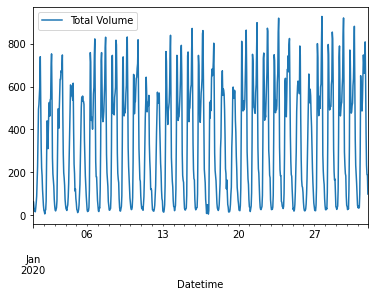

In [25]:
test.plot()

### Preparing testing set

In [30]:
train = pd.read_csv("dataset/processed/traffic-weather-data.csv")
train.shape

(57720, 17)

In [31]:
train['Datetime'] = pd.to_datetime(train['Datetime'])
train = train.set_index('Datetime')

In [32]:
take_n_dates_past = 7
forecast_n_dates_future = 2

n_past = 24*take_n_dates_past
n_future = 24*forecast_n_dates_future

In [33]:
chunk = train.iloc[len(train)-n_future+1-n_past:]

In [34]:
chunk.index.min(), chunk.index.max()

(Timestamp('2019-12-23 01:00:00'), Timestamp('2019-12-31 23:00:00'))

In [ ]:
def AppendRow(df, date, volume):
    

In [35]:
chunk

,Total Volume,Year,Day,sin_Month,cos_Month,sin_DayOfWeek,cos_DayOfWeek,sin_Hour,cos_Hour,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
Datetime,,,,,,,,,,,,,,,,
2019-12-23 01:00:00,23.0,2019,23,-2.449294e-16,1.0,0.000000,1.00000,0.258819,0.965926,5.6,92,0.0,0.0,0.0,0,18.2
2019-12-23 02:00:00,12.0,2019,23,-2.449294e-16,1.0,0.000000,1.00000,0.500000,0.866025,5.7,92,0.0,0.0,0.0,0,18.1
2019-12-23 03:00:00,22.0,2019,23,-2.449294e-16,1.0,0.000000,1.00000,0.707107,0.707107,5.8,92,0.0,0.0,0.0,0,19.0
2019-12-23 04:00:00,32.0,2019,23,-2.449294e-16,1.0,0.000000,1.00000,0.866025,0.500000,6.1,92,0.0,0.0,0.0,1,19.7
2019-12-23 05:00:00,78.0,2019,23,-2.449294e-16,1.0,0.000000,1.00000,0.965926,0.258819,6.6,89,0.0,0.0,0.0,2,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,194.0,2019,31,-2.449294e-16,1.0,0.781831,0.62349,-0.965926,0.258819,7.2,97,0.0,0.0,0.0,3,14.6
2019-12-31 20:00:00,134.0,2019,31,-2.449294e-16,1.0,0.781831,0.62349,-0.866025,0.500000,7.0,97,0.0,0.0,0.0,3,15.0
2019-12-31 21:00:00,71.0,2019,31,-2.449294e-16,1.0,0.781831,0.62349,-0.707107,0.707107,6.6,97,0.0,0.0,0.0,2,14.8


In [45]:
from datetime import datetime, timedelta
x = pd.date_range(start='2019-12-23 01:00:00', end='2019-12-24 01:00:00', freq='H')
m = x[0]
for i, d in enumerate(x):
    print(i, d)

0 2019-12-23 01:00:00
1 2019-12-23 02:00:00
2 2019-12-23 03:00:00
3 2019-12-23 04:00:00
4 2019-12-23 05:00:00
5 2019-12-23 06:00:00
6 2019-12-23 07:00:00
7 2019-12-23 08:00:00
8 2019-12-23 09:00:00
9 2019-12-23 10:00:00
10 2019-12-23 11:00:00
11 2019-12-23 12:00:00
12 2019-12-23 13:00:00
13 2019-12-23 14:00:00
14 2019-12-23 15:00:00
15 2019-12-23 16:00:00
16 2019-12-23 17:00:00
17 2019-12-23 18:00:00
18 2019-12-23 19:00:00
19 2019-12-23 20:00:00
20 2019-12-23 21:00:00
21 2019-12-23 22:00:00
22 2019-12-23 23:00:00
23 2019-12-24 00:00:00
24 2019-12-24 01:00:00
